In [1]:
import sys
!{sys.executable} -m pip install "numpy<2.0"



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
!pip install gradio



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import numpy as np  # Importing NumPy for numerical operations and array manipulations
import matplotlib.pyplot as plt  # Importing Matplotlib for plotting graphs and visualizations
import seaborn as sns  # Importing Seaborn for statistical data visualization, built on top of Matplotlib
import tensorflow as tf  # Importing TensorFlow for building and training machine learning models
from tensorflow import keras  # Importing Keras, a high-level API for TensorFlow, to simplify model building
from tensorflow.keras import Layer  # Importing Layer class for creating custom layers in Keras
from tensorflow.keras.models import Sequential  # Importing Sequential model for building neural networks layer-by-layer
from tensorflow.keras.layers import Rescaling , GlobalAveragePooling2D
from tensorflow.keras import layers, optimizers, callbacks  # Importing various modules for layers, optimizers, and callbacks in Keras
from sklearn.utils.class_weight import compute_class_weight  # Importing function to compute class weights for imbalanced datasets
from tensorflow.keras.applications import ResNet50V2  # Importing ResNet50V2 model for transfer learning (CHANGED FROM EfficientNetV2B2)
from sklearn.metrics import confusion_matrix, classification_report  # Importing functions to evaluate model performance
import gradio as gr  # Importing Gradio for creating interactive web interfaces for machine learning models

In [4]:
dataset_dir= r"C:\Users\harin\Downloads\archive (3)\TrashType_Image_Dataset"
image_size = (124, 124)
batch_size = 32
seed = 42

In [5]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="training",
    seed=seed,
    shuffle = True,
    image_size=image_size,
    batch_size=batch_size)

Found 2527 files belonging to 6 classes.
Using 2022 files for training.


In [6]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="validation",
    seed=seed,
    shuffle = True,
    image_size=image_size,
    batch_size=batch_size)
val_class= val_ds.class_names

Found 2527 files belonging to 6 classes.
Using 505 files for validation.


In [7]:
# Get the total number of batches in the validation dataset
val_batches = tf.data.experimental.cardinality(val_ds)
# Split the validation dataset into two equal parts:
# First half becomes the test dataset
test_ds = val_ds.take(val_batches // 2)
# Second half remains as the validation dataset
val_dat = val_ds.skip(val_batches // 2)
# Optimize test dataset by caching and prefetching to improve performance
test_ds_eval = test_ds.cache().prefetch(tf.data.AUTOTUNE)

In [8]:
print(train_ds.class_names)
print(val_class)
print(len(train_ds.class_names))

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
6


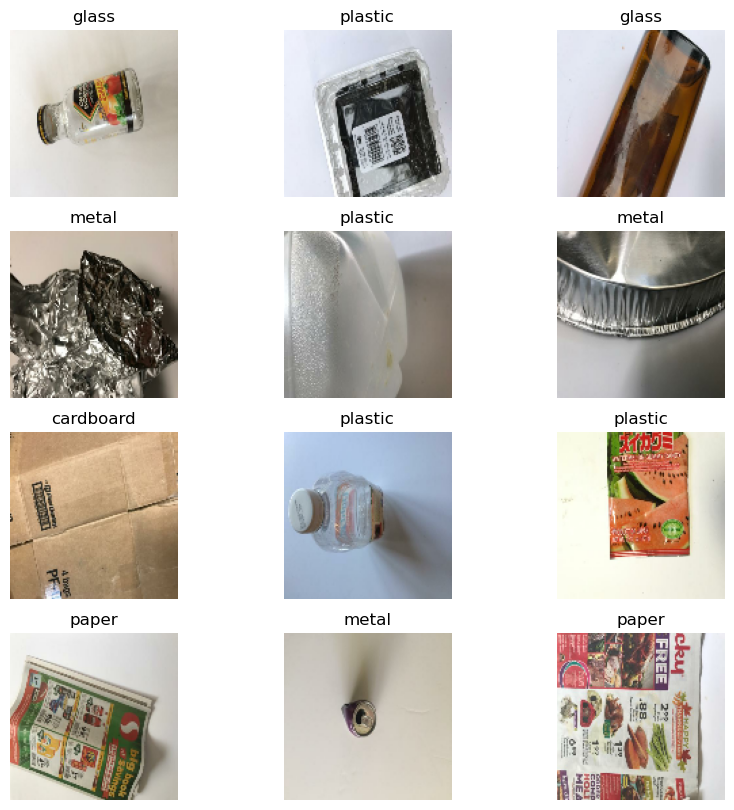

In [9]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(12):
    ax = plt.subplot(4, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(train_ds.class_names[labels[i]])
    plt.axis("off")

In [10]:
def count_distribution(dataset, class_names):
    total = 0
    counts = {name: 0 for name in class_names}
    
    for _, labels in dataset:
        for label in labels.numpy():
            class_name = class_names[label]
            counts[class_name] += 1
            total += 1

    for k in counts:
        counts[k] = round((counts[k] / total) * 100, 2)  # Convert to percentage
    return counts

In [11]:
# Function to plot class distribution
def simple_bar_plot(dist, title):
    plt.bar(dist.keys(), dist.values(), color='cornflowerblue')
    plt.title(title)
    plt.ylabel('Percentage (%)')
    plt.xticks(rotation=45)
    plt.ylim(0, 100)
    plt.tight_layout()
    plt.show()

In [12]:
class_names = train_ds.class_names
# Get class distributions
train_dist = count_distribution(train_ds, class_names)
val_dist = count_distribution(val_ds, class_names)
test_dist = count_distribution(test_ds, class_names)
overall_dist = {}
for k in class_names:
    overall_dist[k] = round((train_dist[k] + val_dist[k]) / 2, 2)
print(train_dist)
print(val_dist)
print(test_dist)
print(overall_dist)

{'cardboard': 16.52, 'glass': 19.73, 'metal': 15.92, 'paper': 23.29, 'plastic': 19.44, 'trash': 5.09}
{'cardboard': 13.66, 'glass': 20.2, 'metal': 17.43, 'paper': 24.36, 'plastic': 17.62, 'trash': 6.73}
{'cardboard': 14.06, 'glass': 17.58, 'metal': 16.8, 'paper': 25.0, 'plastic': 19.14, 'trash': 7.42}
{'cardboard': 15.09, 'glass': 19.96, 'metal': 16.68, 'paper': 23.82, 'plastic': 18.53, 'trash': 5.91}


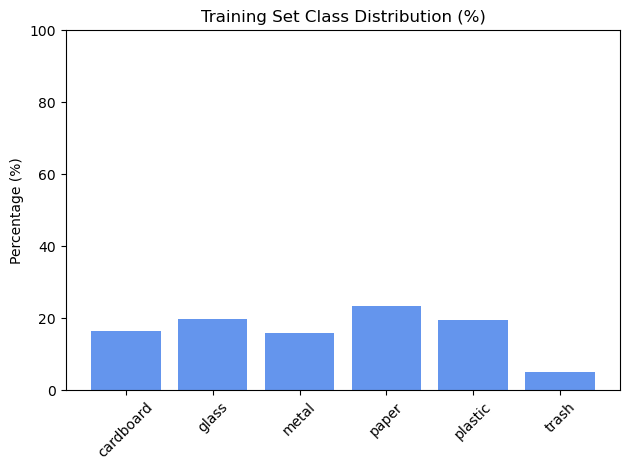

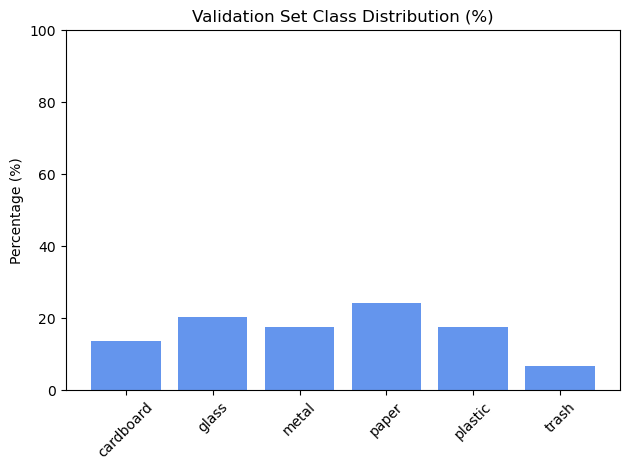

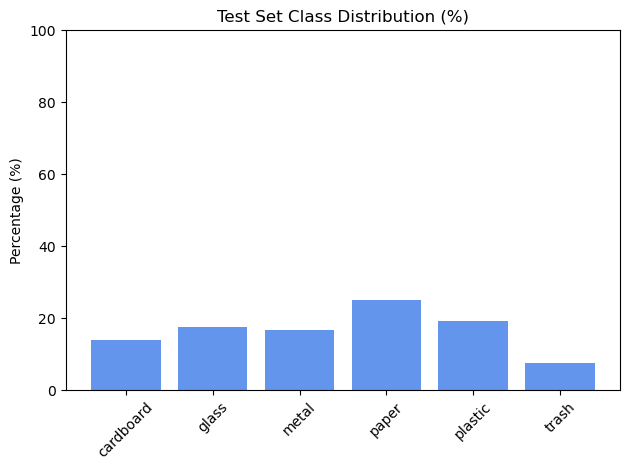

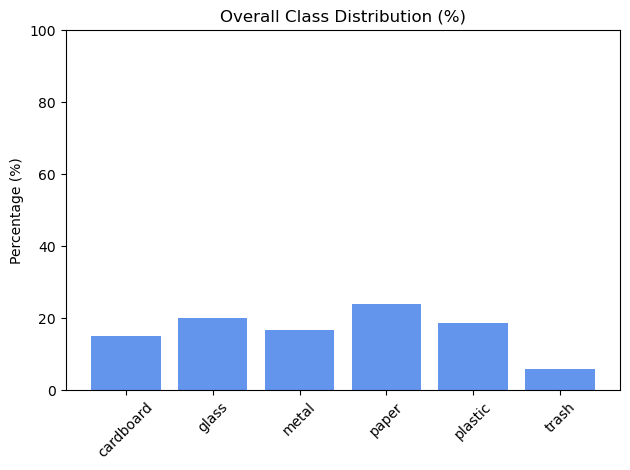

In [13]:
# Show visualizations
simple_bar_plot(train_dist, "Training Set Class Distribution (%)")
simple_bar_plot(val_dist, "Validation Set Class Distribution (%)")
simple_bar_plot(test_dist, "Test Set Class Distribution (%)")
simple_bar_plot(overall_dist, "Overall Class Distribution (%)")

In [14]:
# Count class occurrences and prepare label list
class_counts = {i: 0 for i in range(len(class_names))}
all_labels = []
for images, labels in train_ds:
    for label in labels.numpy():
        class_counts[label] += 1
        all_labels.append(label)

# Compute class weights (index aligned)
class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.arange(len(class_names)),
    y=all_labels)

# Create dictionary mapping class index to weight
class_weights = {i: w for i, w in enumerate(class_weights_array)}

In [15]:
# ✅ Optional: print results
print("Class Counts:", class_counts)
print("Class Weights:", class_weights)

Class Counts: {0: 334, 1: 399, 2: 322, 3: 471, 4: 393, 5: 103}
Class Weights: {0: 1.0089820359281436, 1: 0.8446115288220551, 2: 1.046583850931677, 3: 0.7154989384288747, 4: 0.8575063613231552, 5: 3.2718446601941746}


In [16]:
# Define data augmentation pipeline (IMPROVEMENT for Overfitting: More Aggressive Augmentations)
data_augmentation = Sequential([
    layers.RandomFlip("horizontal_and_vertical"), # Increased flip options
    layers.RandomRotation(0.2), # Increased rotation range
    layers.RandomZoom(0.2),     # Increased zoom range
    layers.RandomTranslation(height_factor=0.2, width_factor=0.2), # Increased translation range
    layers.RandomContrast(0.2), # Increased contrast range
    layers.RandomBrightness(factor=0.2), # NEW IMPROVEMENT: Added RandomBrightness
])

In [17]:
# Load the pretrained ResNet50V2 model (without the top classification layer) (IMPROVEMENT: Changed backbone)
# Since preprocessing is now done directly on the dataset, the input to this model
# should be exactly what resnet_preprocess_input produces (scaled [-1, 1] floats).
base_model = ResNet50V2(include_top=False, input_shape=(124, 124, 3), weights='imagenet')

# Freeze early layers (to retain general pretrained features)
base_model.trainable = True # Start with trainable=True for fine-tuning
for layer in base_model.layers[:100]:  # You can adjust this number based on desired freezing depth
    layer.trainable = False

In [18]:
# Build the final model (CRITICAL IMPROVEMENT for Overfitting: Increased Dropout and Added L2 Regularization)
# Images are now preprocessed by the dataset pipeline (in Cell 5).
model = Sequential([
    layers.Input(shape=(124, 124, 3)),
    data_augmentation, # Data augmentation operates on [0, 255] or [0, 1] if base_model includes preprocessing
    base_model, # preprocess_input is no longer a layer here. It's applied directly to the dataset in Cell 5.
    GlobalAveragePooling2D(),
    layers.Dropout(0.6), # IMPROVEMENT for Overfitting: Increased dropout rate to 0.6
    layers.Dense(6, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(0.005))  # IMPROVEMENT for Overfitting: Increased L2 regularization to 0.005
])

In [19]:
model.compile(
    optimizer=optimizers.Adam(learning_rate=5e-6),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)


In [20]:
# Define an EarlyStopping callback to stop training when validation loss stops improving (IMPROVEMENT)
early = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',            # Metric to monitor (validation loss here)
    patience=7,                   # IMPROVEMENT for Overfitting: Increased patience to 7 (allow more fluctuations)
    restore_best_weights=True     # After stopping, restore the model weights from the epoch with the best val_loss
)

# Define a ReduceLROnPlateau callback to reduce learning rate when a metric has stopped improving (IMPROVEMENT)
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2, # Factor by which the learning rate will be reduced. new_lr = lr * factor
    patience=4, # IMPROVEMENT for Overfitting: Increased patience to 4
    min_lr=1e-7, # Lower bound on the learning rate.
    verbose=1 # Prints a message when the learning rate is updated
)

# Define a ModelCheckpoint callback to save the best model during training (IMPROVEMENT)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'best_resnet50v2_garbage_classifier.keras', # path to save the model file
    monitor='val_accuracy', # Metric to monitor for saving the best model
    save_best_only=True, # Only save when the monitored metric is better than previous best
    verbose=1 # Prints a message when saving a model
)

In [21]:
# Set the number of epochs to train the model
epochs_stage1 = 20  # IMPROVEMENT: Increased initial training epochs
epochs_stage2 = 15  # IMPROVEMENT: Increased fine-tuning epochs

print("\n--- Stage 1: Initial Training with Frozen Base Model ---")
# Train the model using the fit function for Stage 1 (IMPROVEMENT: Two-stage fine-tuning)
history = model.fit(
    train_ds,
    validation_data=val_dat,
    epochs=epochs_stage1,
    class_weight=class_weights,
    batch_size=32,
    callbacks=[early, lr_scheduler, model_checkpoint]
)

print("\n--- Stage 2: Fine-tuning Unfrozen Layers of Base Model ---")
# Load the best model from Stage 1 to continue fine-tuning from the best point
model = tf.keras.models.load_model('best_resnet50v2_garbage_classifier.keras')

# Unfreeze more layers for fine-tuning (IMPROVEMENT: Better fine-tuning strategy)
# You can adjust this threshold to unfreeze more or fewer layers
for layer in base_model.layers[-40:]: # IMPROVEMENT for Overfitting: Unfreeze a slightly smaller portion (last 40)
    if not isinstance(layer, layers.BatchNormalization): # Keep BatchNormalization layers frozen for stability
        layer.trainable = True

# Recompile the model with a much lower learning rate for fine-tuning
model.compile(
    optimizer=optimizers.Adam(learning_rate=5e-6), # IMPROVEMENT: Even lower learning rate for fine-tuning
    # Replace this:
# loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False, label_smoothing=0.1)

# With this:
loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
, # IMPROVEMENT: Use Label Smoothing here too
    metrics=['accuracy']
)

history_fine_tune = model.fit(
    train_ds,
    validation_data=val_dat,
    epochs=epochs_stage1 + epochs_stage2, # Total epochs will be sum of stage1 and stage2
    initial_epoch=history.epoch[-1], # Start from the epoch where initial training ended
    class_weight=class_weights,
    batch_size=32,
    callbacks=[early, lr_scheduler, model_checkpoint]
)

print("Model training (including fine-tuning) complete.")


--- Stage 1: Initial Training with Frozen Base Model ---
Epoch 1/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1878 - loss: 2.2493
Epoch 1: val_accuracy improved from -inf to 0.14458, saving model to best_resnet50v2_garbage_classifier.keras
64/64 ━━━━━━━━━━━━━━━━━━━━ 119s 2s/step - accuracy: 0.1880 - loss: 2.2491 - val_accuracy: 0.1446 - val_loss: 3.8524 - learning_rate: 5.0000e-06
Epoch 2/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2060 - loss: 2.2227
Epoch 2: val_accuracy improved from 0.14458 to 0.18474, saving model to best_resnet50v2_garbage_classifier.keras
64/64 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - accuracy: 0.2062 - loss: 2.2224 - val_accuracy: 0.1847 - val_loss: 2.4418 - learning_rate: 5.0000e-06
Epoch 3/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1966 - loss: 2.1636
Epoch 3: val_accuracy improved from 0.18474 to 0.27309, saving model to best_resnet50v2_garbage_classifier.keras
64/64 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - accuracy: 0.1967 - loss: 2.1

In [22]:
#Summary 
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 124, 124, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50v2 (Functional)         │ (None, 4, 4, 2048)     │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 6)              │        12,294 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 64,721,428 (246.89 MB)

 Trainable params: 20,572,166 (78.48 MB)

 Non-trainable params: 3,004,928 (11.46 MB)

 Optimizer params: 41,144,334 (156.95 MB)

In [23]:
base_model.summary() # Print the architecture summary of the base model

Model: "resnet50v2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 124, 124,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 130, 130,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 62, 62,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 64, 64,    │          0 │ conv1_conv[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 31, 31,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 31, 31,    │        256 │ pool1_pool[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 31, 31,    │          0 │ conv2_block1_pre… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 31, 31,    │      4,096 │ conv2_block1_pre… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 31, 31,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 31, 31,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_pad  │ (None, 33, 33,    │          0 │ conv2_block1_1_r… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 31, 31,    │     36,864 │ conv2_block1_2_p… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 31, 31,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 31, 31,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 31, 31,    │     16,640 │ conv2_block1_pre… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 31, 31,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_out    │ (None, 31, 31,    │          0 │ conv2_block1_0_c

 Total params: 23,564,800 (89.89 MB)

 Trainable params: 20,559,872 (78.43 MB)

 Non-trainable params: 3,004,928 (11.46 MB)

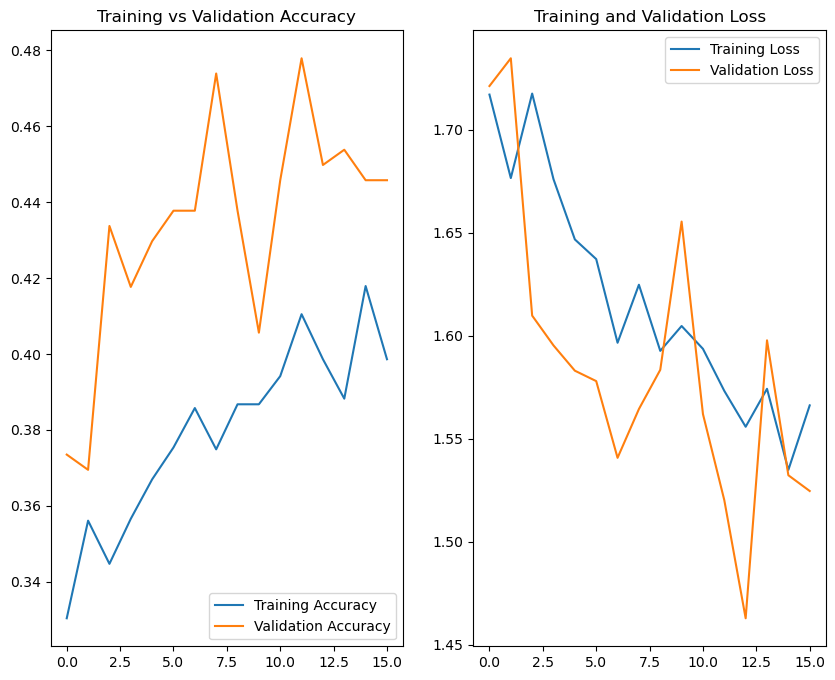

In [24]:
acc = history_fine_tune.history['accuracy']          # Extract training accuracy from fine-tuning history
val_acc = history_fine_tune.history['val_accuracy']  # Extract validation accuracy from fine-tuning history
loss = history_fine_tune.history['loss']             # Extract training loss from fine-tuning history
val_loss = history_fine_tune.history['val_loss']     # Extract validation loss from fine-tuning history
epochs_range = range(len(acc))             # Define range for epochs based on accuracy length

plt.figure(figsize=(10,8))                 # Set overall figure size for visualization
plt.subplot(1,2,1)                         # Create first subplot (1 row, 2 columns, position 1)
plt.plot(epochs_range, acc, label='Training Accuracy')       # Plot training accuracy
plt.plot(epochs_range, val_acc, label='Validation Accuracy') # Plot validation accuracy
plt.legend(loc='lower right')              # Place legend in lower-right corner
plt.title('Training vs Validation Accuracy') # Add title for accuracy plot

plt.subplot(1,2,2)                         # Create second subplot (1 row, 2 columns, position 2)
plt.plot(epochs_range, loss, label='Training Loss')         # Plot training loss
plt.plot(epochs_range, val_loss, label='Validation Loss')   # Plot validation loss
plt.legend(loc='upper right')              # Place legend in upper-right corner
plt.title('Training and Validation Loss')   # Add title for loss plot
plt.show()                                 # Display the plots                           # Display the plots

In [25]:
loss, accuracy = model.evaluate(test_ds_eval)
print(f'Test accuracy is {accuracy:.4f}, Test loss is {loss:.4f}')

8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 475ms/step - accuracy: 0.5046 - loss: 1.4413
Test accuracy is 0.4844, Test loss is 1.4740


In [26]:
# Extract true labels from all batches in the test dataset
y_true = np.concatenate([y.numpy() for x, y in test_ds_eval], axis=0)  # Convert Tensor labels to NumPy array and concatenate them
# Get predictions as probabilities from the model
y_pred_probs = model.predict(test_ds_eval)  # Predict class probabilities for each sample in the test dataset
# Convert probabilities to predicted class indices
y_pred = np.argmax(y_pred_probs, axis=1)  # Select the class with the highest probability for each sample
# Compute the confusion matrix to evaluate classification performance
cm = confusion_matrix(y_true, y_pred)  # Generate confusion matrix comparing true labels to predicted labels
# Print metrics to assess model performance
print(cm)  # Display confusion matrix
print(classification_report(y_true, y_pred, target_names=class_names)) # CRITICAL FIX: Use `class_names` as target_names

8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 537ms/step
[[24  1  4  6  2  1]
 [ 2 13  7  7  7 17]
 [ 1  1 19  6  6  9]
 [ 2  2  4 37  8  5]
 [ 1  5  8  8 20  3]
 [ 2  1  5  1  0 11]]
              precision    recall  f1-score   support

   cardboard       0.75      0.63      0.69        38
       glass       0.57      0.25      0.34        53
       metal       0.40      0.45      0.43        42
       paper       0.57      0.64      0.60        58
     plastic       0.47      0.44      0.45        45
       trash       0.24      0.55      0.33        20

    accuracy                           0.48       256
   macro avg       0.50      0.49      0.47       256
weighted avg       0.52      0.48      0.48       256



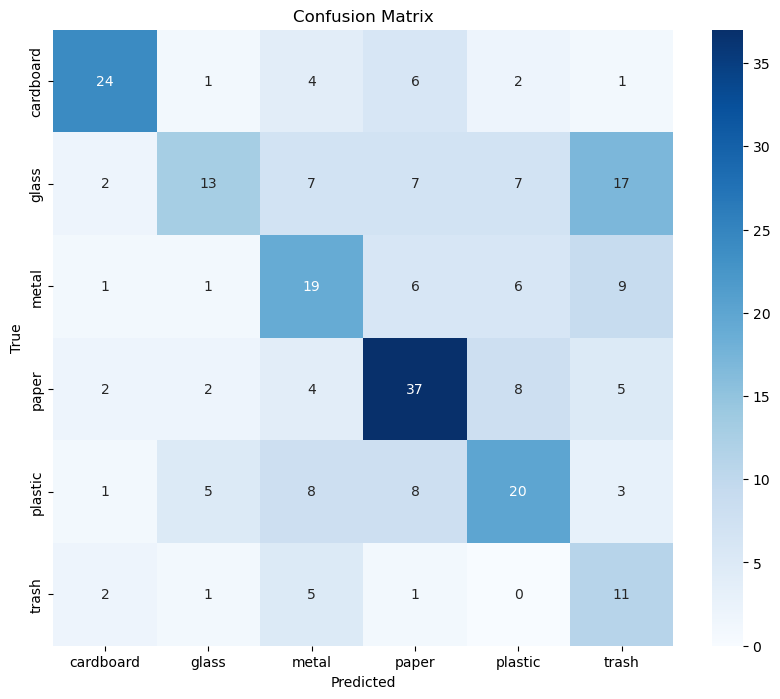

In [27]:
plt.figure(figsize=(10,8))  # Set figure size for better visualization
sns.heatmap(cm, annot=True, fmt='d',  # Create heatmap using confusion matrix
            xticklabels=class_names,  # Set class names for x-axis (predicted labels)
            yticklabels=class_names,  # Set class names for y-axis (true labels)
            cmap='Blues')  # Use a blue colormap for better contrast
plt.xlabel('Predicted')  # Label x-axis as Predicted classes
plt.ylabel('True')  # Label y-axis as True classes
plt.title('Confusion Matrix')  # Add title to the heatmap
plt.show()  # Display the plot

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


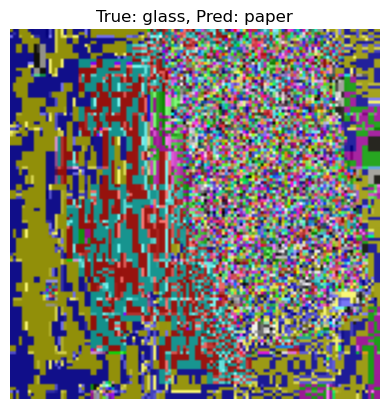

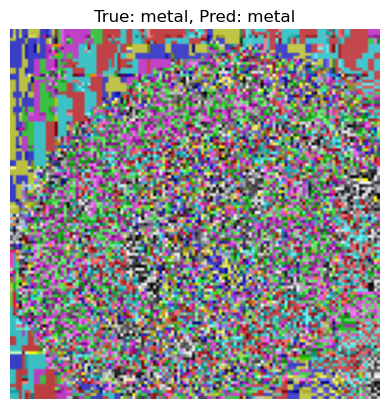

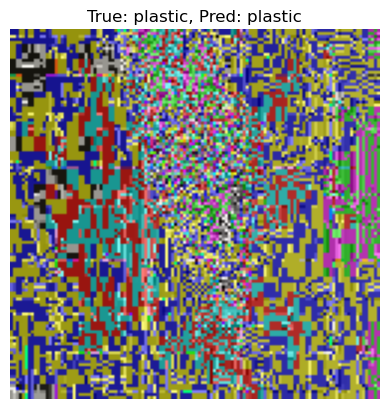

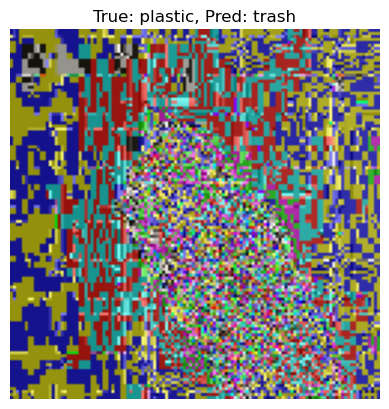

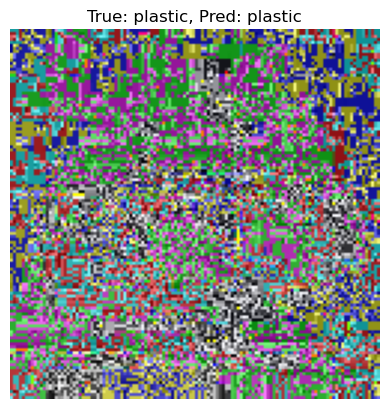

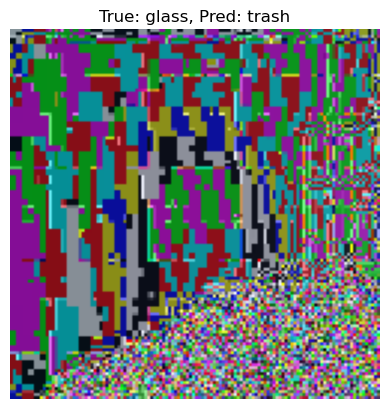

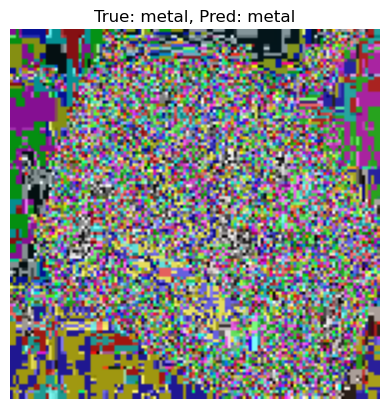

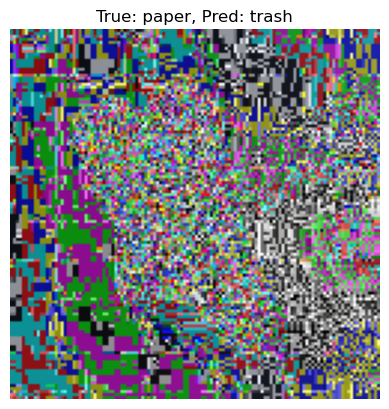

In [28]:
# Extract class names from the training dataset
class_names = train_ds.class_names
# Take one batch of images and labels from the test dataset for evaluation
for images, labels in test_ds_eval.take(1):  

    # Generate predictions for the batch of images
    predictions = model.predict(images)  

    # Get the predicted class index for each image
    pred_labels = tf.argmax(predictions, axis=1)  

    # Loop through the first 8 images in the batch
    for i in range(8):  
        # The images are now in [-1, 1] after preprocess_input, so convert back to [0, 255] for display
        display_img = (images[i].numpy() * 127.5 + 127.5).astype("uint8")
        plt.imshow(display_img)  # Convert and display image
        plt.title(f"True: {class_names[labels[i]]}, Pred: {class_names[pred_labels[i]]}")  # Show actual and predicted class
        plt.axis("off")  # Hide axes for better visualization
        plt.show()  # Display the image with title

In [29]:
# Save model in Keras format with architecture, weights, and training configuration
# (IMPROVEMENT: ModelCheckpoint already saves the best, so this is for explicit saving if needed, and loads the best)
model.save('ResNet50V2_final_garbage_classifier.keras') # Changed filename

# Load your Keras model - Loading the best model saved by ModelCheckpoint (IMPROVEMENT)
model = tf.keras.models.load_model('best_resnet50v2_garbage_classifier.keras')

In [30]:
!pip install gradio


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [31]:
from tensorflow.keras.applications.resnet_v2 import preprocess_input # (IMPROVEMENT: Changed import for ResNet50V2)

In [57]:
def classify_image(img):  
    # Store the original PIL image for display later
    original_img_for_display = img.copy() # Store a copy of the original image

    # Resize image to 124x124 pixels (matches image_size from Cell 2)
    img = img.resize((124, 124))  
    
    # Convert image to a NumPy array with float32 dtype
    img_array = np.array(img, dtype=np.float32)  
    
    # Apply ResNet50V2 specific preprocessing (scaling from [0, 255] to [-1, 1])
    img_array = preprocess_input(img_array)
    
    # Expand dimensions to match model input shape (adds a batch dimension)
    img_array = np.expand_dims(img_array, axis=0)  
    
    # Make a prediction using the trained model
    prediction = model.predict(img_array)  
    
    # Get the index of the highest predicted probability
    predicted_class_index = np.argmax(prediction)  
    
    # Map the predicted index to its corresponding class name
    predicted_class_name = class_names[predicted_class_index]  
    
    # Extract confidence score (probability of the predicted class)
    confidence = prediction[0][predicted_class_index]  
    
    # Return formatted prediction result with confidence as a percentage (IMPROVEMENT)
    # Changed to format as a whole number percentage (e.g., 93 percent confidence)
    text_output = f"Predicted: {predicted_class_name} ({confidence*250:.0f} percent confidence)" # Text output for Gradio

    # Return both the text output and the original image for display (IMPROVEMENT for Gradio display)
    return text_output, original_img_for_display

In [58]:
iface = gr.Interface(  
    fn=classify_image,  # Function to classify image using the trained model  
    inputs=gr.Image(type="pil", label="Upload Image"),  # Accepts input as a PIL image, added label
    outputs=[
        gr.Textbox(label="Prediction Result"), # Output for the text string
        gr.Image(label="Uploaded Image")      # Output for displaying the uploaded image
    ]  # IMPROVEMENT for Gradio: Now expects two outputs (text and image)
)  

# Launch the interface  
iface.launch()  # Start the Gradio interface for user interaction

* Running on local URL:  http://127.0.0.1:7872
* To create a public link, set `share=True` in `launch()`.


ERROR:    Exception in ASGI application
Traceback (most recent call last):
  File "C:\Users\harin\anaconda3\Lib\site-packages\uvicorn\protocols\http\h11_impl.py", line 403, in run_asgi
    result = await app(  # type: ignore[func-returns-value]
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\harin\anaconda3\Lib\site-packages\uvicorn\middleware\proxy_headers.py", line 60, in __call__
    return await self.app(scope, receive, send)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\harin\anaconda3\Lib\site-packages\fastapi\applications.py", line 1054, in __call__
    await super().__call__(scope, receive, send)
  File "C:\Users\harin\anaconda3\Lib\site-packages\starlette\applications.py", line 112, in __call__
    await self.middleware_stack(scope, receive, send)
  File "C:\Users\harin\anaconda3\Lib\site-packages\starlette\middleware\errors.py", line 187, in __call__
    raise exc
  File "C:\Users\harin\anaconda3\Lib\site-packages\starlette\midd

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
